In [53]:
from models import SimpleConv, BrainModule
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
from torch import nn, optim
import numpy as np
from collections import namedtuple
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import correlation

In [54]:
device = torch.device('cuda:7')
model = BrainModule()
# model = BrainModule(output_size=91168)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.to(device);

In [55]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Number of parameters: {param.numel()}")
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Layer: spatial_attention.weight | Number of parameters: 220320
Layer: spatial_attention.bias | Number of parameters: 270
Layer: linear_proj1.weight | Number of parameters: 218700
Layer: linear_proj1.bias | Number of parameters: 270
Layer: linear_proj2.weight | Number of parameters: 218700
Layer: linear_proj2.bias | Number of parameters: 270
Layer: res_dilated_conv1.weight | Number of parameters: 259200
Layer: res_dilated_conv1.bias | Number of parameters: 320
Layer: res_dilated_conv2.weight | Number of parameters: 307200
Layer: res_dilated_conv2.bias | Number of parameters: 320
Layer: linear_proj3.weight | Number of parameters: 1966080
Layer: linear_proj3.bias | Number of parameters: 2048
Layer: mlp_proj.weight | Number of parameters: 1572864
Layer: mlp_proj.bias | Number of parameters: 768
Total number of parameters: 4767330


In [56]:
data_array = np.load('cache/processed_data/BIGMEG1/train_thingsmeg_sub-BIGMEG1.npy', mmap_mode='r')
labels_array = np.load('cache/extracted_embeddings/BIGMEG1/train_cliptext1b_sub-BIGMEG1.npy', mmap_mode='r')
# labels_array = np.load('cache/extracted_embeddings/BIGMEG1/train_clipvision1b_sub-BIGMEG1.npy', mmap_mode='r')
labels_array = labels_array[:, 0]
# labels_array = np.load('cache/extracted_embeddings/BIGMEG1/train_autokl1b_sub-BIGMEG1.npy', mmap_mode='r')
data_array.shape, labels_array.shape

((22248, 272, 120), (22248, 768))

In [57]:
# Assuming your data array is named 'data_array' and your labels array is named 'labels_array'
data_tensor = torch.tensor(data_array).float()
labels_tensor = torch.tensor(labels_array).float()

# Create a TensorDataset from your data tensor and labels tensor
dataset = TensorDataset(data_tensor, labels_tensor)

# Create a DataLoader from your TensorDataset
dataloader = DataLoader(dataset, batch_size=256, shuffle=True) # original batch size 32

KeyboardInterrupt: 

In [ ]:
# Assuming total_data is your total dataset
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_data, val_data = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_data, batch_size=32)
val_dataloader = DataLoader(val_data, batch_size=32)

# Training loop
for epoch in range(150):  # 100 epochs
    # Training phase
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        val_loss = 0
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
    model.train()  # Set the model back to training mode

    clear_output(wait=False)
    print(f'Epoch {epoch+1} / {150}, Training Loss: {loss.item()}, Validation Loss: {val_loss}')

Epoch 150 / 150, Training Loss: 0.0003068363294005394, Validation Loss: 0.00032335301844536196


In [ ]:
# 0.00032319269479817844, 0.0005876266763412527

In [ ]:
test_data = np.load('cache/processed_data/BIGMEG1/test_thingsmeg_sub-BIGMEG1.npy', mmap_mode='r')
test_labels = np.load('cache/extracted_embeddings/BIGMEG1/test_cliptext1b_sub-BIGMEG1.npy', mmap_mode='r')
# test_labels = np.load('cache/extracted_embeddings/BIGMEG1/test_clipvision1b_sub-BIGMEG1.npy', mmap_mode='r')
test_labels = test_labels[:, 0]
# test_labels = np.load('cache/extracted_embeddings/BIGMEG1/test_autokl1b_sub-BIGMEG1.npy', mmap_mode='r')

In [ ]:
test_data_tensor = torch.tensor(test_data).float()
test_labels_tensor = torch.tensor(test_labels).float()

test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# Testing loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    preds = []
    # true_labels = []
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
    #     true_labels.extend(labels.cpu().numpy())
    # correlation_matrix = np.corrcoef(preds, true_labels)
    # avg_correlation = np.mean(correlation_matrix)
    # print(f'Average correlation between predicted and test labels: {avg_correlation}')
    pred_labels = np.array(preds)

In [ ]:
# Compute the Euclidean distances
euclidean_distances = np.array([np.linalg.norm(u - v) for u, v in zip(pred_labels, test_labels)])
correlation_distances = np.array([correlation(u, v) for u, v in zip(pred_labels, test_labels)])
# Compute the average Euclidean distance
average_euclidean_distance = euclidean_distances.mean()
correlations = (1 - correlation_distances).mean()
correlations, average_euclidean_distance

(0.8331349489889841, 0.4900690695350204)

In [ ]:
# 0.840537235832449
# 0.8405433424275223
# 0.8405434170403377

In [ ]:
# unmodified regression performance
test_labels = np.load('cache/extracted_embeddings/BIGMEG1/test_cliptext1b_sub-BIGMEG1.npy', mmap_mode='r')
test_labels = test_labels[:, 0, :]
pred_labels = np.load('cache/predicted_embeddings/BIGMEG1/thingsmeg_regress_cliptext1b_sub-BIGMEG1.npy', mmap_mode='r')
pred_labels = pred_labels[:, 0, :]
# Compute the Euclidean distances
euclidean_distances = np.array([np.linalg.norm(u - v) for u, v in zip(pred_labels, test_labels)])
correlation_distances = np.array([correlation(u, v) for u, v in zip(pred_labels, test_labels)])
# Compute the average Euclidean distance
average_euclidean_distance = euclidean_distances.mean()
correlations = (1 - correlation_distances).mean()
print('cliptext 1st embedding:')
print(correlations, average_euclidean_distance)

cliptext 1st embedding:
0.7132301973694442 0.6739413756833288


In [ ]:
# NSD fMRI regression performance
test_labels = np.load('/mnt/sphere/projects/brain-diffuser/data/extracted_features/subj01/nsd_cliptext_test.npy', mmap_mode='r')
test_labels = test_labels[:, 0, :]
pred_labels = np.load('/mnt/sphere/projects/brain-diffuser/data/predicted_features/subj01/nsd_cliptext_predtest_nsdgeneral.npy', mmap_mode='r')
pred_labels = pred_labels[:, 0, :]
# Compute the Euclidean distances
euclidean_distances = np.array([np.linalg.norm(u - v) for u, v in zip(pred_labels, test_labels)])
correlation_distances = np.array([correlation(u, v) for u, v in zip(pred_labels, test_labels)])
# Compute the average Euclidean distance
average_euclidean_distance = euclidean_distances.mean()
correlations = (1 - correlation_distances).mean()
print('cliptext 1st embedding:')
print(correlations, average_euclidean_distance)
test_labels = np.load('/mnt/sphere/projects/brain-diffuser/data/extracted_features/subj01/nsd_clipvision_test.npy', mmap_mode='r')
test_labels = test_labels[:, 0, :]
pred_labels = np.load('/mnt/sphere/projects/brain-diffuser/data/predicted_features/subj01/nsd_clipvision_predtest_nsdgeneral.npy', mmap_mode='r')
pred_labels = pred_labels[:, 0, :]
# Compute the Euclidean distances
euclidean_distances = np.array([np.linalg.norm(u - v) for u, v in zip(pred_labels, test_labels)])
correlation_distances = np.array([correlation(u, v) for u, v in zip(pred_labels, test_labels)])
# Compute the average Euclidean distance
average_euclidean_distance = euclidean_distances.mean()
correlations = (1 - correlation_distances).mean()
print('clipvision 1st embedding:')
print(correlations, average_euclidean_distance)

cliptext 1st embedding:
0.9999999999999798 0.08716399866359316
clipvision 1st embedding:
0.7206470311671278 0.7445045003979572


In [ ]:
# save pred autokl
preds_array = np.array(preds)
np.save('cache/predicted_embeddings/BIGMEG1/thingsmeg_dummymodule_autokl1b_sub-BIGMEG1.npy', preds_array)
# 0.2509697010681101

In [ ]:
# save pred cliptext
preds_array = np.array(preds)
preds_repeated = np.repeat(preds_array[:, np.newaxis, :], 77, axis=1)
# np.save('cache/predicted_embeddings/BIGMEG1/thingsmeg_dummymodule_cliptext1b_sub-BIGMEG1.npy', preds_repeated)

In [ ]:
# save pred clipvision
preds_array = np.array(preds)
regress_labels = np.load('cache/predicted_embeddings/BIGMEG1/thingsmeg_regress_clipvision1b_sub-BIGMEG1.npy')
regress_labels[:, 0] = preds_array
# np.save('cache/predicted_embeddings/BIGMEG1/thingsmeg_dummyregress_clipvision1b_sub-BIGMEG1.npy', regress_labels)

In [ ]:
regress_labels.shape

(2400, 257, 768)

In [ ]:
# Training loop
for epoch in range(22248//256):  # 100 epochs
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    clear_output(wait=False)
    print(f'Epoch {epoch+1} / {22248//256}, Loss: {loss.item()}')

Epoch 10 / 86, Loss: 0.0003172225260641426


KeyboardInterrupt: 

In [ ]:
np.array(preds).shape 

(2400, 768)

In [ ]:
test_labels.shape

(2400, 77, 768)

In [ ]:
test_labels = np.load('cache/extracted_embeddings/BIGMEG1/test_clipvision1b_sub-BIGMEG1.npy', mmap_mode='r')
test_labels = test_labels[:, 0]
regression_labels = np.load('cache/predicted_embeddings/BIGMEG1/thingsmeg_regress_clipvision1bopt_sub-BIGMEG1.npy', mmap_mode='r')
regression_labels = regression_labels[:, 0]
np.corrcoef(regression_labels, test_labels).mean()

0.5575363570371152

In [ ]:
test_labels = np.load('cache/extracted_embeddings/BIGMEG1/test_autokl1b_sub-BIGMEG1.npy', mmap_mode='r')
# regression_labels = np.load('cache/predicted_embeddings/BIGMEG1/thingsmeg_regress_autokl1b_sub-BIGMEG1.npy', mmap_mode='r')
pred_labels = preds_array.copy()
# np.corrcoef(regression_labels, test_labels).mean()
# np.mean([stats.pearsonr(pred_labels[i], test_labels[i])[0] for i in range(len(pred_labels))])

# Compute the correlation distances
correlation_distances = np.array([correlation(u, v) for u, v in zip(pred_labels, test_labels)])

# Convert the correlation distances to correlation coefficients
correlations = 1 - correlation_distances
correlations.mean()

0.0004041415369711861

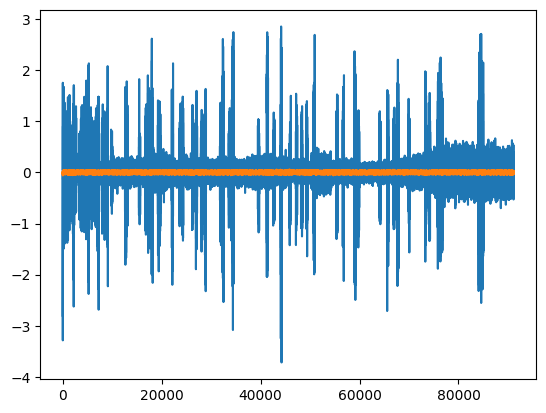

In [ ]:
plt.plot(test_labels[0])
plt.plot(regression_labels[0])

In [ ]:
test_labels.shape

(2400, 91168)

In [ ]:
data_array = np.ones((1000, 272, 120))
labels_array = np.ones((1000, 768)) + 5

In [ ]:
# Assuming your data array is named 'data_array' and your labels array is named 'labels_array'
data_tensor = torch.tensor(data_array).float()
labels_tensor = torch.tensor(labels_array).float()

# Create a TensorDataset from your data tensor and labels tensor
dataset = TensorDataset(data_tensor, labels_tensor)

# Create a DataLoader from your TensorDataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# pbar = tqdm(total=100, desc='Epoch: ')
# Training loop
for epoch in range(20000//32):  # 100 epochs
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    clear_output(wait=False)
    print(f'Epoch {epoch+1} / {20000//32}, Loss: {loss.item()}')
    # torch.cuda.synchronize()
    # pbar.set_postfix(Loss=loss.item())
    # pbar.update()
    # pbar.refresh()
# pbar.close()

Epoch 625 / 625, Loss: 1.325312970479331e-09


In [ ]:
model(torch.ones(272,120).to('cuda:7')).mean()

tensor(6.0001, device='cuda:7', grad_fn=<MeanBackward0>)

In [ ]:
in_channels = {'meg': 272}
model_chout = 768
n_subjects = 1
# args_simpleconv = {'concatenate': False, 'depth': 10, 'linear_out': False, 'complex_out': True, 'kernel_size': 3, 'dilation_growth': 2, 'dilation_period': 5, 'skip': True, 'post_skip': False, 'growth': 1.0, 'scale': None, 'rewrite': False, 'groups': 1, 'glu': 2, 'glu_context': 1, 'glu_glu': True, 'gelu': True, 'dual_path': 0, 'conv_dropout': 0.0, 'dropout_input': 0.0, 'batch_norm': True, 'relu_leakiness': 0.0, 'subject_dim': 0, 'subject_layers': True, 'embedding_scale': 1.0, 'subject_layers_dim': 'input', 'subject_layers_id': False, 'n_fft': None, 'fft_complex': True, 'merger': True, 'merger_pos_dim': 2048, 'merger_channels': 270, 'merger_dropout': 0.2, 'merger_penalty': 0.0, 'merger_per_subject': False, 'dropout': 0.0, 'dropout_rescale': True, 'initial_linear': 270, 'initial_depth': 1, 'initial_nonlin': False, 'hidden': {'meg': 320}}
args_simpleconv = {'concatenate': False, 'depth': 10, 'linear_out': False, 'complex_out': True, 'kernel_size': 3, 'dilation_growth': 2, 'dilation_period': 5, 'skip': True, 'post_skip': False, 'growth': 1.0, 'scale': None, 'rewrite': False, 'groups': 1, 'glu': 2, 'glu_context': 1, 'glu_glu': True, 'gelu': True, 'dual_path': True, 'conv_dropout': 0.0, 'dropout_input': 0.0, 'batch_norm': True, 'relu_leakiness': 0.0, 'subject_dim': 0, 'subject_layers': True, 'embedding_scale': 1.0, 'subject_layers_dim': 'input', 'subject_layers_id': False, 'n_fft': None, 'fft_complex': True, 'merger': True, 'merger_pos_dim': 2048, 'merger_channels': 270, 'merger_dropout': 0.2, 'merger_penalty': 0.0, 'merger_per_subject': False, 'dropout': 0.0, 'dropout_rescale': True, 'initial_linear': 270, 'initial_depth': 1, 'initial_nonlin': False, 'hidden': {'meg': 320}}
subjects = torch.tensor([1]) # 1

In [ ]:
simpleconv = SimpleConv(in_channels=in_channels, out_channels=model_chout,
                           n_subjects=n_subjects, **args_simpleconv)

In [ ]:
simpleconv

SimpleConv(
  (merger): ChannelMerger(
    (embedding): FourierEmb()
  )
  (initial_linear): Sequential(
    (0): Conv1d(270, 270, kernel_size=(1,), stride=(1,))
  )
  (subject_layers): SubjectLayers(270, 270, 1)
  (agg_layer): AdaptiveAvgPool1d(output_size=1)
  (mlp_head_clip): Sequential(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1024, out_features=768, bias=True)
  )
  (mlp_head_mse): Sequential(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1024, out_features=768, bias=True)
  )
  (dual_path): DualPathRNN(
    (lstms): ModuleList(
      (0-3): 4 x LSTM(320, 320)
    )
  )
  (final): Sequential(
    (0): Conv1d(320, 640, kernel_size=(1,), stride=(1,))
    (1): GELU(approximate='none')
    (2): ConvTranspose1d(640, 768, kernel_size=(1,), stride=(1,))
  )
  (encoders): ModuleDict(
    (meg): ConvSequence(
      (sequence): 

In [ ]:
simpleconv.final

Sequential(
  (0): Conv1d(320, 640, kernel_size=(1,), stride=(1,))
  (1): GELU(approximate='none')
  (2): ConvTranspose1d(640, 768, kernel_size=(1,), stride=(1,))
)

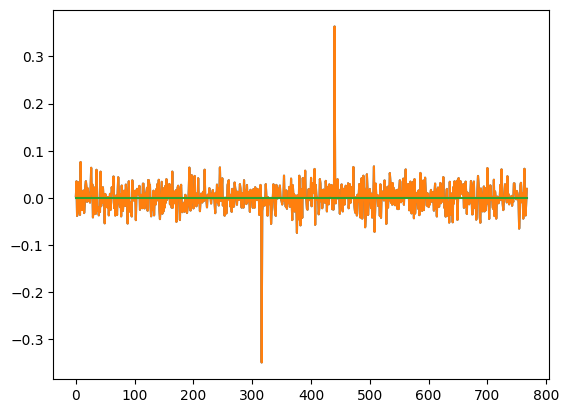

In [ ]:
plt.plot(data_array[0][0])
plt.plot(data_array[0][1])
plt.plot(data_array[52][0] - data_array[900][0])
# plt.plot(data_array[5][0])

In [ ]:
# print(torch.cuda.device_count())
# for i in range(torch.cuda.device_count()):
# 	print(torch.cuda.get_device_name(i))
# 	print(torch.cuda.get_device_properties(i).total_memory / 1e9)
# 	print(torch.cuda.mem_get_info(i)[0] / 1e9)

In [ ]:
model.initial_linear

Sequential(
  (0): Conv1d(272, 270, kernel_size=(1,), stride=(1,))
)

In [ ]:
model(torch.randn(1, 272, 120).to('cuda:7'), subjects = subjects.to('cuda:7'))
# model(torch.randn(1, 272, 120), subjects = subjects)
# model(torch.randn(1, 272, 120).to('cuda:0'), subjects = subjects)

TypeError: forward() got an unexpected keyword argument 'subjects'

In [ ]:
As = torch.randn(1, 270, 120).to('cuda:0')
Bs = torch.randn(1, 270, 270).to('cuda:0')
# torch.einsum('bij,bjk->bik', As, Bs).shape
torch.einsum('bct,bcd->bdt', As, Bs).shape

torch.Size([1, 270, 120])

In [ ]:
next(iter(torch.randn(1, 120, 272).to_sparse().values()))

tensor(1.0413)

In [ ]:
torch.randn(1, 120, 272).to_sparse().values().shape

torch.Size([32640])

In [ ]:
fake_data = np.zeros((100, 272))

In [ ]:
DataLoader(fake_data, batch_size=10, shuffle=True)

In [ ]:
for batch in DataLoader(fake_data, batch_size=10, shuffle=True):
    print(batch.shape)
    print(model(batch).shape)
    break

torch.Size([10, 272])


RuntimeError: values expected sparse tensor layout but got Strided

In [ ]:
Datasets = namedtuple("Datasets", "train valid test")

In [ ]:
Datasets

__main__.Datasets

In [ ]:
batch.values()

RuntimeError: values expected sparse tensor layout but got Strided

In [ ]:
# subjects = torch.tensor([18, 22, 10, 22, 23, 21, 18,  9,  0,  7, 12, 22, 19,  3,  9, 12, 13,  4,
#         20,  0, 17, 25, 21, 21,  3, 17, 17, 12,  0, 18,  6, 20, 22, 12, 11,  3,
#         15, 26,  5,  0, 21,  0, 14,  8,  7,  9, 12, 18, 17, 23,  6,  6,  9, 24,
#         14, 19,  9, 23, 17,  6, 21, 20, 21,  3,  4,  3,  8,  5,  8, 11, 15,  4,
#         14,  0,  8,  5,  1,  9,  1,  1, 25,  1,  1,  8, 10, 22,  9, 17, 23, 24,
#          7,  1, 10,  1, 26,  1, 25, 23, 21,  5,  4,  3, 15, 25, 25, 21, 18, 13,
#         15,  8,  4, 25,  4, 14,  4, 14, 19, 10, 18, 17, 25, 10, 10, 23,  1, 12,
#          5, 22, 26,  3, 10, 15,  8, 18, 21,  3, 18,  4, 21, 22, 12,  7,  1, 26,
#         21,  3, 16, 18,  3, 17, 17, 12, 18, 12,  7,  6, 16,  9, 24, 18,  2,  3,
#          8,  1, 20,  3, 21,  6,  3, 13,  6,  9,  4,  9, 12,  9, 16,  6,  5, 17,
#         14, 25, 25,  5,  2, 13,  3, 17, 25, 21, 19, 17, 18,  1, 18,  6, 24, 24,
#          0,  7, 23,  1,  6,  1, 23,  1,  7, 21, 25, 23, 12, 13,  9, 11, 26,  5,
#         18,  8,  5, 12,  3, 24,  0, 17, 18, 17, 19,  8,  5, 18,  3,  5, 16, 15,
#         24, 25, 26, 22, 11,  7,  0, 15, 14,  0, 13,  9,  1, 16, 22,  7, 10,  1,
#         24,  3,  4, 25]) # 256